# Setup: Import packages and load configuration

In [1]:
import json
import os
import numpy
import pandas
import copy
import conntility, connalysis

from scipy.spatial import KDTree
from pnagm import util, nngraph, instance, test

from matplotlib import pyplot as plt



## Loading data
Here, we load the data for our analysis. We begin by loading a configuration file that specifies which connectome to use as a reference and the parameters to use for the model approximating it.

You can, of course, customize the configuration or create your own.

Then we load the connectome that is referenced in the configuration.

### Analysis parameters
Additionally, we set two parameters of this anlysis. Note they are not parameters of the connectome model. We simply parameterize how many stochastic instances to build and analyze and where to put the plots.

In [2]:
config_fn = "../configs/pnagm_L45E_SSCX_yscale_experimental_v1p5.json"
n_instances = 5
plot_out = "plots_sscx"
if not os.path.exists(plot_out):
    os.makedirs(plot_out)

with open(config_fn, "r") as fid:
    cfg = json.load(fid)

if "fn" in cfg["make_points"]:
    microns_fn = cfg["make_points"]["fn"]
    print("""
A reference connectome is expected at path {0},
          please place it there or update the path in the configuration file!
""".format(microns_fn))
    
    # For internal use only :)
    microns_connectome_prefix = "/Users/mwr/Documents/artefacts/connectomes"
    cfg["make_points"]["fn"] = os.path.join(microns_connectome_prefix, cfg["make_points"]["fn"])

pts, microns = util.points_from_microns(cfg["make_points"])
reference = microns.matrix > 0


A reference connectome is expected at path SSCX_O1_cmat.h5,
          please place it there or update the path in the configuration file!

27968
11905


## Building the model
Here, we build the specified number of instances of the model.
For convenience of analysis, we put their sparse adjacency matrices into a ConnectivityGroup object.

In [3]:
mdl_instances = []
mdls = []
for _ in range(n_instances):
    mdl_instance, M = util.create_neighbor_spread_graph(pts, cfg, reference=microns)
    print("Mean degree of neighbor graph: {0}".format(M.nnz / M.shape[0]))
    mdl_instances.append(mdl_instance)
    print("Mean degree of instance: {0}".format(mdl_instance.nnz / mdl_instance.shape[0]))
    mdl = conntility.ConnectivityMatrix(mdl_instance, vertex_properties=microns._vertex_properties)
    mdls.append(mdl)
mdls = conntility.ConnectivityGroup(pandas.DataFrame({"instance": range(n_instances)}),mdls)

Used custom weights!
Mean degree of neighbor graph: 98.11306173876523
Mean degree of instance: 164.8327593448131
Used custom weights!
Mean degree of neighbor graph: 98.21066778664427
Mean degree of instance: 167.26770264594708
Used custom weights!
Mean degree of neighbor graph: 98.09248215035699
Mean degree of instance: 166.80655186896263
Used custom weights!
Mean degree of neighbor graph: 98.11742965140697
Mean degree of instance: 165.44241915161697
Used custom weights!
Mean degree of neighbor graph: 98.24393112137757
Mean degree of instance: 165.1580008399832


### Setting up the comparison tests and the distance-dependent control

Here, we are bulding a "DDtest" object that serves as the basis for many of the tests comparing model to reference. Most tests are in some way distance-dependent, so this object stores a lot of information about all pairwise distances. Hence, it takes around 90 seconds to construct.

**Note that you only need to re-evaluate this cell when the reference data used changed. If you just want to adjust some parameters of the model, you do not need to re-run it!**

We also build some instances of a distance-dependent control here.


In [4]:
DD = test.DDtest(microns)

bin_centers = 0.5 * (test.dbins[1:] + test.dbins[:-1])

p = DD.for_matrix(reference)
logp = numpy.log(p)
valid = ~(numpy.isnan(logp) | numpy.isinf(logp))
f_params = numpy.polyfit(bin_centers[valid], logp[valid], 1)

a = numpy.exp(f_params[1])
b = -f_params[0]

ctrl_instances = []
ctrls = []
for _ in range(n_instances):
    ctrl_instance = connalysis.randomization.run_DD2(len(DD.m), a, b, DD.m.vertices[["x", "y", "z"]].values)
    ctrl_instances.append(ctrl_instance)
    ctrl = conntility.ConnectivityMatrix(ctrl_instance, vertex_properties=microns._vertex_properties)
    ctrls.append(ctrl)
ctrls = conntility.ConnectivityGroup(pandas.DataFrame({"instance": range(n_instances)}), ctrls)


/var/folders/py/wqmt8l2s5zb8fhrxbd_b258w0000gn/T/ipykernel_27007/1388774208.py:6: RuntimeWarning: divide by zero encountered in log
  logp = numpy.log(p)


## Basic analyses

Here, we load a configuration file that references a number of simple analyses whose results can be summed up by a single number. We run it on reference, model and control.

In [5]:
with open("../configs/analysis_config.json", "r") as fid:
    analyses = json.load(fid)

def reciprocal_overexpression(m, pts):
    if m.nnz == 0:
        return numpy.nan
    mdl_coo = m.tocoo()
    edge_indices = pandas.DataFrame({"row": mdl_coo.row, "col": mdl_coo.col})
    e_rv = edge_indices.reset_index(drop=True).rename(columns={"row": "col", "col": "row"})[["row", "col"]]
    e = pandas.concat([e_rv, edge_indices.reset_index(drop=True)], axis=0)
    vc = e.drop_duplicates(keep="last").index.value_counts()
    count_rc = (vc == 1).sum()
    count_all = len(edge_indices)
    n_pairs = mdl_coo.shape[0] * (mdl_coo.shape[1] - 1)
    return (count_rc / n_pairs) / ((count_all / n_pairs) ** 2)

analyses["analyses"]["rec_overexpression"] = {
    "source": reciprocal_overexpression,
    "output": "Value"
}

pandas.concat([
    pandas.Series(microns.analyze(analyses)),
    pandas.DataFrame(mdls.analyze(analyses)).transpose(),
    pandas.DataFrame(ctrls.analyze(analyses)).transpose()
], axis=1, keys=["reference", "model", "control"], names=["Data source"])

Data source            reference         model                              \
                               0          (0,)          (1,)          (2,)   
con_prob            7.654470e-02  7.889271e-02  7.927828e-02  7.943642e-02   
nnz                 1.950417e+06  1.962334e+06  1.991322e+06  1.985832e+06   
skewness_eff        1.003975e+00  4.773140e-01  4.550506e-01  4.474045e-01   
cn_bias_aff         2.517950e+00  2.680854e+00  2.697237e+00  2.695248e+00   
skewness_aff        7.779065e-01  7.834143e-01  7.856774e-01  7.962077e-01   
mean_degree         1.638318e+02  1.648328e+02  1.672677e+02  1.668066e+02   
cn_bias_eff         2.604946e+00  2.667680e+00  2.652504e+00  2.639398e+00   
rec_overexpression  1.906635e+00  1.910929e+00  1.929606e+00  1.915710e+00   

Data source                                          control                \
                            (3,)          (4,)          (0,)          (1,)   
con_prob            7.870746e-02  7.857342e-02  7.452426e-02  7.474189e-02   
nnz                 1.969592e+06  1.966206e+06  2.022299e+06  2.027869e+06   
skewness_eff        4.805713e-01  4.829654e-01 -2.619276e-03  9.129308e-04   
cn_bias_aff         2.654479e+00  2.685927e+00  1.429985e+00  1.429104e+00   
skewness_aff        7.715823e-01  7.769091e-01  9.353727e-03  2.267199e-02   
mean_degree         1.654424e+02  1.651580e+02  1.698697e+02  1.703376e+02   
cn_bias_eff         2.632569e+00  2.659857e+00  1.430452e+00  1.428527e+00   
rec_overexpression  1.903301e+00  1.916167e+00  1.946140e+00  1.957313e+00   

Data source                                                   
                            (2,)          (3,)          (4,)  
con_prob            7.444368e-02  7.455513e-02  7.471553e-02  
nnz                 2.027386e+06  2.024806e+06  2.024531e+06  
skewness_eff        1.687368e-02 -1.690944e-03  2.172258e-02  
cn_bias_aff         1.430034e+00  1.428120e+00  1.429174e+00  
skewness_aff        1.299736e-02  3.425306e-03  1.796156e-02  
mean_degree         1.702970e+02  1.700803e+02  1.700572e+02  
cn_bias_eff         1.429209e+00  1.428525e+00  1.429806e+00  
rec_overexpression  1.960245e+00  1.947753e+00  1.965501e+00

### Plot: Degree distributions

/Users/mwr/Documents/repositories/local_connectivity_model/src/pnagm/test.py:106: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  fit_res.append(Hs.applymap(fit_log_distribution))
/Users/mwr/Documents/repositories/local_connectivity_model/src/pnagm/test.py:70: RuntimeWarning: divide by zero encountered in log10
  logx = numpy.log10(x)
/Users/mwr/Documents/repositories/local_connectivity_model/src/pnagm/test.py:106: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  fit_res.append(Hs.applymap(fit_log_distribution))
/Users/mwr/Documents/repositories/local_connectivity_model/src/pnagm/test.py:70: RuntimeWarning: divide by zero encountered in log10
  logx = numpy.log10(x)


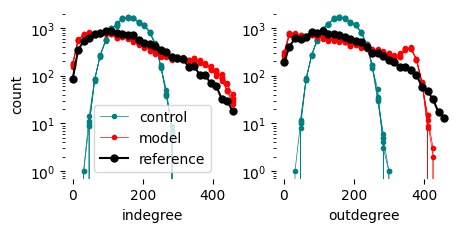

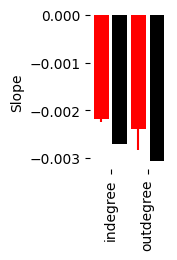

In [6]:
fig_distr, fig_slopes = DD.degree_distribution_analysis([mdls, ctrls], ["model", "control"])
fig_distr.savefig(os.path.join(plot_out, "m_degree_distributions.pdf"))
fig_slopes.savefig(os.path.join(plot_out, "m_degrees_slopes.pdf"))


### Plot: two-d distance dependence of connectivity

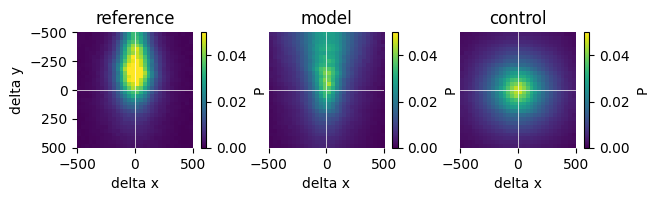

In [7]:
from matplotlib import pyplot as plt
from pnagm.test import dbins2d

clim = (0, 0.05)
fig = plt.figure(figsize=(7, 1.5))

Is = [DD.p_2d_ref[(1, 2)],
     numpy.nanmean(numpy.dstack([DD.twod_for_matrix(_instance, (1, 2))
                                 for _instance in mdl_instances]), axis=2),
     numpy.nanmean(numpy.dstack([DD.twod_for_matrix(_instance, (1, 2))
                                     for _instance in ctrl_instances]), axis=2)                            
    ]
ttls = ["reference", "model", "control"]
i = 1

for I, ttl in zip(Is, ttls):
    ax = fig.add_subplot(1, 3, i)
    if i > 1:
        ax.set_yticks([])
    else:
        ax.set_ylabel("delta y")
    i += 1
    img = ax.imshow(I, clim=clim,
            extent=[dbins2d[0], dbins2d[-1], dbins2d[-1], dbins2d[0]])
    plt.colorbar(img, label="P")
    ax.set_xlim(ax.get_xlim()); ax.set_ylim(ax.get_ylim())
    ax.plot(ax.get_xlim(), [0, 0], color="white", linewidth=0.5)
    ax.plot([0, 0], ax.get_xlim(), color="white", linewidth=0.5)
    ax.set_frame_on(False)
    ax.set_xlabel("delta x")
    ax.set_title(ttl)

fig.savefig(os.path.join(plot_out, "m_2d_distance_dependence.pdf"))


### Plot: Percentage of downwards facing connections

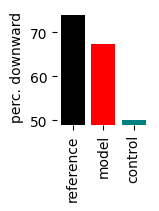

In [8]:
def percent_downwards(instance):
    dy = numpy.diff(instance.edge_associated_vertex_properties("y"), axis=1)
    return 100 * numpy.mean(dy > 0)

ref = percent_downwards(microns)
v_mdl = [percent_downwards(mdls[i]) for i in mdls.index]
v_ctrl = [percent_downwards(ctrls[i]) for i in ctrls.index]

fig = plt.figure(figsize=(1.2, 1.5))
ax = fig.gca()

bot = 49.0

ax.bar(0, ref - bot, color="black", bottom=bot)
ax.bar(1, numpy.mean(v_mdl) - bot, color="red", bottom=bot)
ax.errorbar(1, numpy.mean(v_mdl), yerr=numpy.std(v_mdl), color="red")
ax.bar(2, numpy.mean(v_ctrl) - bot, color="teal", bottom=bot)
ax.errorbar(2, numpy.mean(v_ctrl), yerr=numpy.std(v_ctrl), color="teal")
ax.set_ylabel("perc. downward")
ax.set_xticks([0, 1, 2]); ax.set_xticklabels(["reference", "model", "control"], rotation="vertical")
ax.set_frame_on(False)

fig.savefig(os.path.join(plot_out, "m_perc_down.pdf"))


### Plot: one-d distance-dependence of connectivity

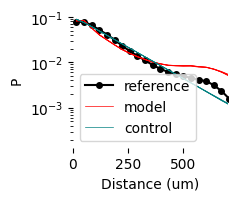

In [ ]:
from matplotlib import pyplot as plt
from pnagm import test

bin_centers = 0.5 * (test.dbins[1:] + test.dbins[:-1])

fig = plt.figure(figsize=(2., 1.75))
ax = fig.gca()

ax.plot(bin_centers, DD.p_ref, color="black", lw=1.5, marker="o", ms=4, label="reference")
for i, _instance in enumerate(mdl_instances):
    lbl = None
    if i == 0: lbl = "model"
    ax.plot(bin_centers, DD.for_matrix(_instance), label=lbl, color="red", lw=0.5)
for i, _instance in enumerate(ctrl_instances):
    lbl = None
    if i == 0: lbl = "control"
    ax.plot(bin_centers, DD.for_matrix(_instance), label=lbl, color="teal", lw=0.5)

ax.set_yscale("log")
ax.set_xlim([0, 700])
ax.set_frame_on(False)
ax.set_xlabel("Distance (um)")
ax.set_ylabel("P")
plt.legend()

fig.savefig(os.path.join(plot_out, "m_1d_distance_dependence.pdf"))

### Plot: Nearest neighbor interaction
This plot contrasts the overall connection probability at various distances to the connection probability conditional on the nearest neighbor being connected. If the two are different it proves a statistical dependence between the two potential edges.

/Users/mwr/Documents/repositories/local_connectivity_model/src/pnagm/test.py:164: RuntimeWarning: invalid value encountered in divide
  ret = H_x_con / H_x_all  # Probability that a neuron with connected NN is connected itself (per dist bin)


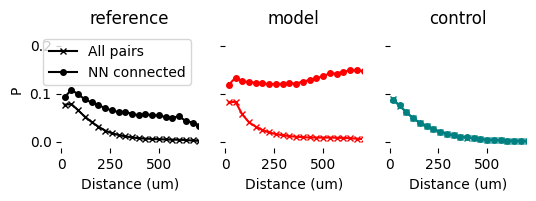

In [10]:
fig = plt.figure(figsize=(6, 1.5))
axes = fig.subplots(1, 3, sharey=True)
xlim = [0, 700]

ax = axes[0]
ax.plot(bin_centers, DD.p_ref, color="black", marker='x', lw=1.5, ms=4, label="All pairs")
ax.plot(bin_centers, DD.dist_and_nn_analysis(DD.m.matrix), color="black", marker='o', lw=1.5, ms=4, label="NN connected")
ax.set_ylabel("P")
ax.set_xlim(xlim)
ax.legend()
ax.set_title("reference")
ax.set_frame_on(False)
ax.set_xlabel("Distance (um)")

ax = axes[1]
p_basics = numpy.vstack([DD.for_matrix(_instance) for _instance in mdl_instances])
p_nn_con = numpy.vstack([DD.dist_and_nn_analysis(_instance) for _instance in mdl_instances])
ax.plot(bin_centers, numpy.mean(p_basics, axis=0), color="red", marker='x', lw=1.5, ms=4)
ax.errorbar(bin_centers, numpy.mean(p_nn_con, axis=0), yerr=numpy.std(p_nn_con, axis=0),
             color="red", marker='o', lw=1.5, ms=4)
ax.set_xlim(xlim)
ax.set_title("model")
ax.set_frame_on(False)
ax.set_xlabel("Distance (um)")

ax = axes[2]
p_basics = numpy.vstack([DD.for_matrix(_instance) for _instance in ctrl_instances])
p_nn_con = numpy.vstack([DD.dist_and_nn_analysis(_instance) for _instance in ctrl_instances])
ax.plot(bin_centers, numpy.mean(p_basics, axis=0), color="teal", marker='x', lw=1.5, ms=4)
ax.errorbar(bin_centers, numpy.mean(p_nn_con, axis=0), yerr=numpy.std(p_nn_con, axis=0),
             color="teal", marker='o', lw=1.5, ms=4)
ax.set_xlim(xlim)
ax.set_title("control")
ax.set_frame_on(False)
ax.set_xlabel("Distance (um)")

fig.savefig(os.path.join(plot_out, "m_distance_and_nn_analysis.pdf"))



### Plot: Simplex counts

[2025-04-30 12:41:27,540] WARNING: No seed among keyword arguments
[2025-04-30 12:41:34,042] WARNING: No seed among keyword arguments
[2025-04-30 12:41:41,281] WARNING: No seed among keyword arguments
[2025-04-30 12:41:48,735] WARNING: No seed among keyword arguments
[2025-04-30 12:41:56,214] WARNING: No seed among keyword arguments
[2025-04-30 12:42:03,566] WARNING: No seed among keyword arguments
[2025-04-30 12:42:11,014] WARNING: No seed among keyword arguments
[2025-04-30 12:42:17,811] WARNING: No seed among keyword arguments
[2025-04-30 12:42:24,381] WARNING: No seed among keyword arguments
[2025-04-30 12:42:30,942] WARNING: No seed among keyword arguments
[2025-04-30 12:42:37,421] WARNING: No seed among keyword arguments


/Users/mwr/Documents/repositories/local_connectivity_model/src/pnagm/test.py:229: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/Users/mwr/Documents/repositories/local_connectivity_model/src/pnagm/test.py:229: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


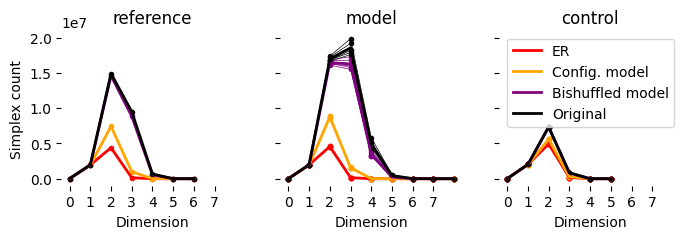

In [11]:
def simplex_counts_over_instances(instances):
    all_smplx_model = pandas.concat([
        test.DDtest.simplex_counts_and_controls(_instance)
        for _instance in instances
    ], axis=1, names=["instance"], keys=range(len(instances)))
    return all_smplx_model

src_instances = [mdl_instances, ctrl_instances]
src_labels = ["model", "control"]

fig = DD.simplex_count_analysis(src_instances, src_labels)

fig.savefig(os.path.join(plot_out, "m_simplex_analysis.pdf"))


### Plot: Pathway-specific connection probabilities

[[1.         0.79516388]
 [0.79516388 1.        ]]


/var/folders/py/wqmt8l2s5zb8fhrxbd_b258w0000gn/T/ipykernel_27007/1734792343.py:63: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(v_x, v_y, marker=mrk_pre, c=col_post)
/var/folders/py/wqmt8l2s5zb8fhrxbd_b258w0000gn/T/ipykernel_27007/1734792343.py:64: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(j, i, marker=mrk_pre, c=col_post)


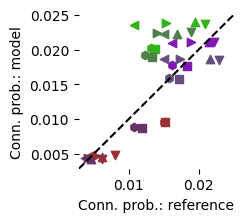

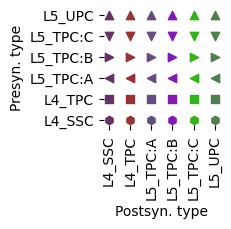

In [12]:
col = "cell_type"
col = "mtype"

c = DD.m.vertices[col].value_counts().sort_index()
nrml = c.values.reshape((-1, 1)) * c.values.reshape((1, -1))

p_ref = DD.m.condense(col).array / nrml
mrks = {
    "L4a": "s",
    "L4b": "h",
    "L4c": "p",
    "L5ET": "v",
    "L5NP": "^",
    "L5a": "<",
    "L5b": ">",
    "L2a": "s",
    "L2b": "h",
    "L2c": "p",
    "L3a": "v",
    "L3b": "^",
    "L4_TPC": "s",
    "L5_TPC:A": "<",
    "L5_TPC:B": ">",
    "L4_SSC": "h",
    "L5_UPC": "^",
    "L5_TPC:C": "v"
}
cols = {
    "L4a": [0.6, 0.2, 0.2],
    "L4b": [0.4, 0.2, 0.4],
    "L4c": [0.2, 0.2, 0.6],
    "L5ET": [0.2, 0.7, 0.1],
    "L5NP": [0.3, 0.5, 0.3],
    "L5a": [0.4, 0.3, 0.5],
    "L5b": [0.5, 0.1, 0.7],
    "L2a": [0.6, 0.2, 0.2],
    "L2b": [0.4, 0.2, 0.4],
    "L2c": [0.2, 0.2, 0.6],
    "L3a": [0.2, 0.7, 0.1],
    "L3b": [0.3, 0.5, 0.3],
    "L4_TPC": [0.6, 0.2, 0.2],
    "L5_TPC:A": [0.4, 0.3, 0.5],
    "L5_TPC:B": [0.5, 0.1, 0.7],
    "L4_SSC": [0.4, 0.2, 0.4],
    "L5_UPC": [0.3, 0.5, 0.3],
    "L5_TPC:C": [0.2, 0.7, 0.1]
}
p_mdls = numpy.dstack([mdls[i].condense(col).array / nrml
                       for i in mdls.index])

fig = plt.figure(figsize=(2, 2))
fig2 = plt.figure(figsize=(1.5, 1.5))
ax = fig.gca()
ax2 = fig2.gca()

for i, pre in enumerate(c.index.values):
    mrk_pre = mrks[pre]
    for j, post in enumerate(c.index.values):
        col_post = cols[post]
        v_x = p_ref[i, j]
        v_ys = p_mdls[i, j, :]
        v_y = numpy.mean(v_ys)
        ax.scatter(v_x, v_y, marker=mrk_pre, c=col_post)
        ax2.scatter(j, i, marker=mrk_pre, c=col_post)
ax.set_frame_on(False)
lims = numpy.vstack([ax.get_xlim(), ax.get_ylim()])
lims = [lims[:, 0].min(), lims[:, 1].max()]
ax.set_xlim(lims); ax.set_ylim(lims)
ax.plot(ax.get_xlim(), ax.get_xlim(), color="black", ls="--")
ax.set_xlabel("Conn. prob.: reference")
ax.set_ylabel("Conn. prob.: model")

ax2.set_xticks(range(len(c.index)))
ax2.set_yticks(range(len(c.index)))
ax2.set_xticklabels(c.index, rotation="vertical")
ax2.set_yticklabels(c.index)
ax2.set_xlabel("Postsyn. type")
ax2.set_ylabel("Presyn. type")
ax2.set_frame_on(False)


print(numpy.corrcoef(p_ref.flatten(), p_mdls.mean(axis=2).flatten()))
fig.savefig(os.path.join(plot_out, "m_pathway_con_probs_model.pdf"))
fig2.savefig(os.path.join(plot_out, "m_pathway_con_probs_legend.pdf"))

[[1.         0.46102749]
 [0.46102749 1.        ]]


/var/folders/py/wqmt8l2s5zb8fhrxbd_b258w0000gn/T/ipykernel_27007/1124827655.py:23: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(v_x, v_y, marker=mrk_pre, c=col_post)
/var/folders/py/wqmt8l2s5zb8fhrxbd_b258w0000gn/T/ipykernel_27007/1124827655.py:24: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(j, i, marker=mrk_pre, c=col_post)


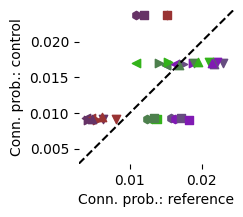

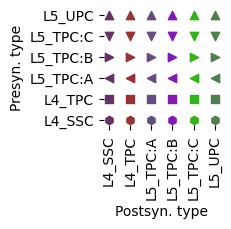

In [13]:
clim = [0, 0.01]

c = DD.m.vertices[col].value_counts().sort_index()
nrml = c.values.reshape((-1, 1)) * c.values.reshape((1, -1))

p_ref = DD.m.condense(col).array / nrml

p_mdls = numpy.dstack([ctrls[i].condense(col).array / nrml
                       for i in ctrls.index])

fig = plt.figure(figsize=(2, 2))
fig2 = plt.figure(figsize=(1.5, 1.5))
ax = fig.gca()
ax2 = fig2.gca()

for i, pre in enumerate(c.index.values):
    mrk_pre = mrks[pre]
    for j, post in enumerate(c.index.values):
        col_post = cols[post]
        v_x = p_ref[i, j]
        v_ys = p_mdls[i, j, :]
        v_y = numpy.mean(v_ys)
        ax.scatter(v_x, v_y, marker=mrk_pre, c=col_post)
        ax2.scatter(j, i, marker=mrk_pre, c=col_post)
ax.set_frame_on(False)
lims = numpy.vstack([ax.get_xlim(), ax.get_ylim()])
lims = [lims[:, 0].min(), lims[:, 1].max()]
ax.set_xlim(lims); ax.set_ylim(lims)
ax.plot(ax.get_xlim(), ax.get_xlim(), color="black", ls="--")
ax.set_xlabel("Conn. prob.: reference")
ax.set_ylabel("Conn. prob.: control")

ax2.set_xticks(range(len(c.index)))
ax2.set_yticks(range(len(c.index)))
ax2.set_xticklabels(c.index, rotation="vertical")
ax2.set_yticklabels(c.index)
ax2.set_xlabel("Postsyn. type")
ax2.set_ylabel("Presyn. type")
ax2.set_frame_on(False)


print(numpy.corrcoef(p_ref.flatten(), p_mdls.mean(axis=2).flatten()))
fig.savefig(os.path.join(plot_out, "m_pathway_con_probs_control.pdf"))